# Single Subject Segmentation Q1K

In [5]:
#use these commented parameters for testing this notebook outside of the automated loop of q1k_automated_reports.ipynb
subject_id = "1057P"
task_id = "GO"
session_id = "01"
run_id = "1"

##use these parameters when executing this notebook from the automation notebook..
#subject_id = ""
#task_id = ""
#session_id = ""
#run_id = ""


In [6]:
# import packages
import mne
import mne_bids
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from pathlib import Path
import shutil
import pylossless as ll
from autoreject import AutoReject

import warnings
warnings.filterwarnings('ignore')


# Set the parameters and read the pylossless data.

In [7]:
project_path = "/project/def-emayada/q1k/experimental/"
pylossless_path = "derivatives/pylossless/"
sync_loss_path = "derivatives/sync_loss/"
segment_path = "derivatives/segment/"

bids_path = mne_bids.BIDSPath(
    subject=subject_id, session=session_id, task=task_id, run="1", datatype="eeg", suffix="eeg",root=project_path + pylossless_path + sync_loss_path
)
print(bids_path)

/project/def-emayada/q1k/experimental/derivatives/pylossless/derivatives/sync_loss/sub-1057P/ses-01/eeg/sub-1057P_ses-01_task-GO_run-1_eeg.edf


In [8]:
# Read the BIDS pylossless output file..
eeg_raw = mne_bids.read_raw_bids(bids_path=bids_path, verbose=False)

In [9]:
#show channel types...
channel_types = eeg_raw.get_channel_types()
print("Channel Types:", channel_types)
print("Channel Names:", eeg_raw.info['ch_names'])

Channel Types: ['eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'misc', 'misc', 'misc', 'stim', 'misc', 'misc', 'misc']
Channel Names: ['E1', 'E2

Using matplotlib as 2D backend.


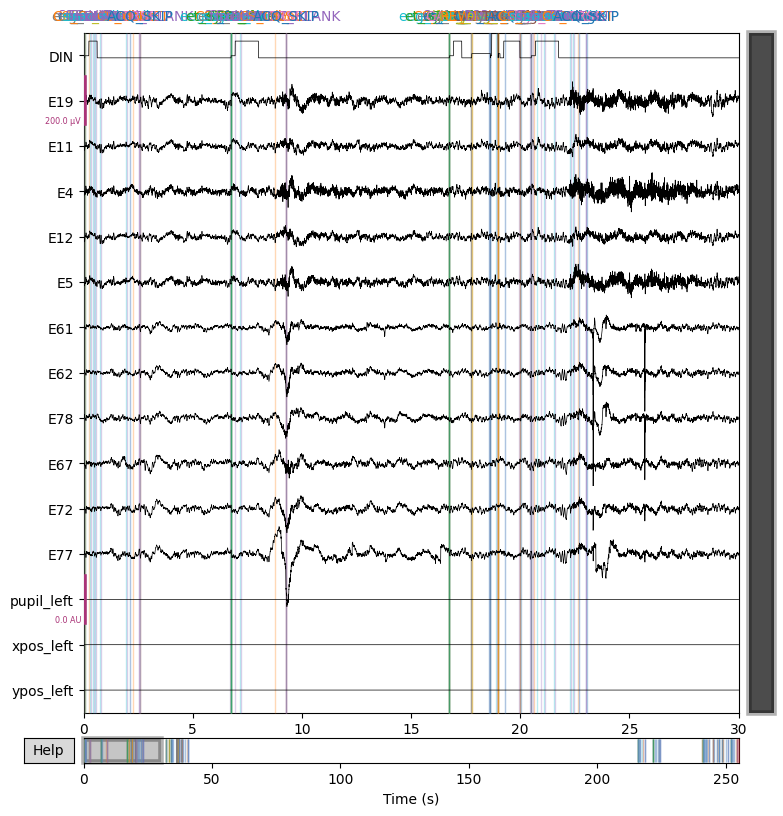

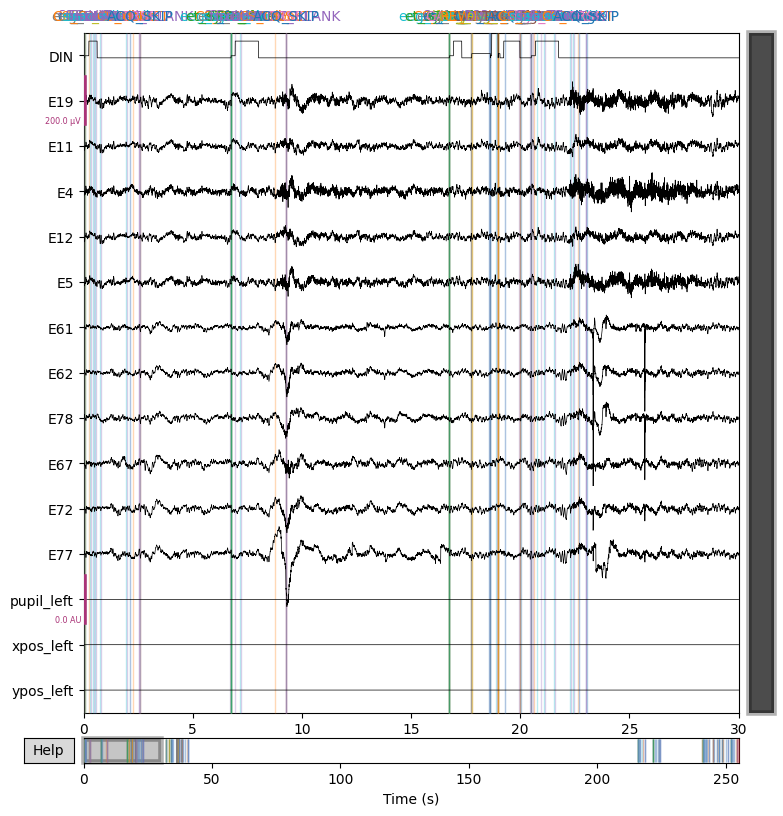

In [10]:
# Define a few channel groups of interest and plot the data
frontal = ["E19", "E11", "E4", "E12", "E5"]
occipital = ["E61", "E62", "E78", "E67", "E72", "E77"]
din = ["DIN"]
pupil = ["pupil_left"]
x_pos = ["xpos_left"]
y_pos = ["ypos_left"]

#scale_dict = dict(eeg=1e-4, eyegaze=30, pupil=30)
scale_dict = dict(eeg=1e-4, eyegaze=30, pupil=30)

# picks must be numeric (not string) when passed to `raw.plot(..., order=)`
picks_idx = mne.pick_channels(eeg_raw.ch_names, din + frontal + occipital + pupil + x_pos + y_pos, ordered=True)
#picks_idx = mne.pick_channels(eeg_raw.ch_names, frontal + occipital, ordered=True)
eeg_raw.plot(start=0,duration=30,order=picks_idx, scalings=scale_dict)

# Segment the data to 'sv06' and 'sv15'

In [11]:
# Get the events form the annotations
eeg_events, eeg_event_dict  = mne.events_from_annotations(eeg_raw)

## Relabel condition vars for niceness
#eeg_event_dict['sv/visual/disp/sv06'] = eeg_event_dict.pop('sv06')
#eeg_event_dict['sv/visual/disp/sv15'] = eeg_event_dict.pop('sv15')
#eeg_event_dict['sv/visual/disp/sv06_d'] = eeg_event_dict.pop('sv06_d')
#eeg_event_dict['sv/visual/disp/sv15_d'] = eeg_event_dict.pop('sv15_d')

Used Annotations descriptions: ['ACQ_SKIP', 'CS_ONSET', 'CS_SPIN', 'DISPLAY_BLANK', 'GAZE_ON_PS', 'GAZE_TO_CS', 'GAZE_TO_WRONG_SIDE', 'INVALID_TRIAL', 'ONSET_200MS', 'ONSET_PS', 'REWARD_ONSET', 'STIM_d', 'TIMEOUT', 'TRIAL_END', 'TRSP', 'VALID_TRIAL', 'blink', 'dbbc', 'dbgc', 'dboc', 'dfbc', 'dfbc_d', 'dfgc', 'dfgc_d', 'dfoc', 'dfoc_d', 'dggc', 'drgc', 'droc', 'dsgc', 'dsoc', 'dtgc', 'dtoc', 'eeg_DIN2', 'eeg_DIN3', 'eeg_sync_time', 'et_DIN2', 'et_DIN4', 'et_sync_time', 'fixation', 'gcoc', 'gegc', 'gfgc', 'gfoc', 'saccade']


In [12]:
#reject_criteria = {'eeg': 400e-6}

In [13]:
#create a new dictionary keeping only keys that start with 'd' or 'g' ('display' and 'gaze' onset events)
epoch_eeg_event_dict = {key: value for key, value in eeg_event_dict.items() if key.startswith(('d', 'g'))}
#print the filtered dictionary
print(epoch_eeg_event_dict)

#epoch to the filtered dictionary .. select specific conditions at a later stage..
epochs = mne.Epochs(eeg_raw, eeg_events, event_id=epoch_eeg_event_dict, tmin=-1, tmax=1.0, on_missing='warn', event_repeated='drop')
#epochs = epochs[['dtbc', 'dtoc', 'dtgc']]
display(epochs)

##apply autoreject to the epochs..
#ar = AutoReject()
#epochs.load_data()
#epochs_clean = ar.fit_transform(epochs)

#save the cleaned epochs...
epochs.save(project_path + pylossless_path + sync_loss_path + segment_path + 'epoch_fif_files/GO/' + bids_path.basename + '_epo.fif', overwrite=True)

{'dbbc': 18, 'dbgc': 19, 'dboc': 20, 'dfbc': 21, 'dfbc_d': 22, 'dfgc': 23, 'dfgc_d': 24, 'dfoc': 25, 'dfoc_d': 26, 'dggc': 27, 'drgc': 28, 'droc': 29, 'dsgc': 30, 'dsoc': 31, 'dtgc': 32, 'dtoc': 33, 'gcoc': 41, 'gegc': 42, 'gfgc': 43, 'gfoc': 44}
Not setting metadata
47 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated


<Epochs | 47 events (good & bad), -1 – 1 s (baseline -1 – 0 s), ~154 kB, data not loaded,
 'dbbc': 7
 'dbgc': 2
 'dboc': 3
 'dfbc': 7
 'dfbc_d': 7
 'dfgc': 2
 'dfgc_d': 2
 'dfoc': 3
 'dfoc_d': 3
 'dggc': 1
 and 10 more events ...>

Overwriting existing file.
Loading data for 47 events and 2001 original time points ...
3 bad epochs dropped
Loading data for 1 events and 2001 original time points ...
Overwriting existing file.
Loading data for 44 events and 2001 original time points ...


In [15]:
required_conditions = {'dtbc', 'dtoc', 'dtgc'}
available_conditions = set(epochs.event_id.keys())
if required_conditions.issubset(available_conditions):
    print("All required conditions are present.")
else:
    print("Missing conditions:", required_conditions - available_conditions)

Missing conditions: {'dtbc'}


In [ ]:
# peak... at the EEG channel types
channel_types = epochs.get_channel_types()
print("EEG Channel Types:", channel_types)
print("EEG Channel Names:", epochs.info['ch_names'])

In [ ]:
evokeds = {'dtbc': epochs['dtbc'].average(picks=['eeg','misc']), 'dtoc': epochs['dtoc'].average(picks=['eeg','misc']), 'dtgc': epochs['dtgc'].average(picks=['eeg','misc'])}
mne.write_evokeds(project_path + pylossless_path + sync_loss_path + segment_path + 'erp_fif_files/GO/' + bids_path.basename + '_erp.fif',list(evokeds.values()), overwrite=True)

# Plot ERP envelopes and topographies

In [ ]:
evokeds['dtbc'].plot_joint(picks=['eeg'], title='target baseline')

In [ ]:
evokeds['dtoc'].plot_joint(picks=['eeg'],title='target overlap')

In [ ]:
evokeds['dtgc'].plot_joint(picks=['eeg'],title='target gap')

# Plot the ERP overlay

In [ ]:
# Plot ERP overlay
mne.viz.plot_compare_evokeds(evokeds, picks=['E6'], combine='mean')

In [ ]:
# Plot ERP overlay
mne.viz.plot_compare_evokeds(evokeds, picks=['pupil_left'], combine='mean')

In [ ]:
# Plot ERP overlay
mne.viz.plot_compare_evokeds(evokeds, picks=['xpos_left'], combine='mean')

In [ ]:
#epochs_condition_1 = epochs['sv06']
#epochs_condition_2 = epochs['sv15']
ch_name = 'E70'

decim = 2
freqs = np.arange(3, 50, 2)  # define frequencies of interest
n_cycles = freqs / 2

#epochs_chan = epochs.pick_channels([ch_name])


In [ ]:
decim = 2
freqs = np.arange(2, 50, 2)  # define frequencies of interest
n_cycles = freqs / 2

pow_1, itc_1 = mne.time_frequency.tfr_morlet(
    epochs['dtgc'],
    freqs,
    picks=ch_name,
    n_cycles=n_cycles,
    decim=decim,
    return_itc=True,
    average=True,
)

pow_2, itc_2 = mne.time_frequency.tfr_morlet(
    epochs['dtoc'],
    freqs,
    picks=ch_name,
    n_cycles=n_cycles,
    decim=decim,
    return_itc=True,
    average=True,
)

itc_dat_1 = itc_1.data[0, :, :]  # only 1 channel as 3D matrix
pow_dat_1 = pow_1.data[0, :, :]  # only 1 channel as 3D matrix

itc_dat_2 = itc_2.data[0, :, :]  # only 1 channel as 3D matrix
pow_dat_2 = pow_2.data[0, :, :]  # only 1 channel as 3D matrix

In [ ]:
times = 1e3 * epochs['dtgc'].times  # change unit to ms

fig1, (ax1t, ax1b) = plt.subplots(2, 1, figsize=(6, 4))
fig1.subplots_adjust(0.12, 0.08, 0.96, 0.94, 0.2, 0.43)

ax1t.imshow(
    pow_dat_1,
    extent=[times[0], times[-1], freqs[0], freqs[-1]],
    aspect="auto",
    origin="lower",
    cmap="RdBu_r",
)

ax1b.imshow(
    itc_dat_1,
    extent=[times[0], times[-1], freqs[0], freqs[-1]],
    aspect="auto",
    origin="lower",
    cmap="RdBu_r",
)

ax1t.set_ylabel("Frequency (Hz)")
ax1t.set_title(f"target gap Induced power ({ch_name})")
ax1b.set_title(f"target gap Inter Trial Coherence ({ch_name})")
ax1b.set_xlabel("Time (ms)")

plt.show()

In [ ]:
fig2, (ax2t, ax2b) = plt.subplots(2, 1, figsize=(6, 4))
fig2.subplots_adjust(0.12, 0.08, 0.96, 0.94, 0.2, 0.43)

ax2t.imshow(
    pow_dat_2,
    extent=[times[0], times[-1], freqs[0], freqs[-1]],
    aspect="auto",
    origin="lower",
    cmap="RdBu_r",
)

ax2b.imshow(
    itc_dat_2,
    extent=[times[0], times[-1], freqs[0], freqs[-1]],
    aspect="auto",
    origin="lower",
    cmap="RdBu_r",
)

ax2t.set_ylabel("Frequency (Hz)")
ax2t.set_title(f"target overlap Induced power ({ch_name})")
ax2b.set_title(f"target overlap Inter Trial Coherence ({ch_name})")
ax2b.set_xlabel("Time (ms)")

plt.show()

In [ ]:
fig3, (ax3t, ax3b) = plt.subplots(2, 1, figsize=(6, 4))
fig3.subplots_adjust(0.12, 0.08, 0.96, 0.94, 0.2, 0.43)

ax3t.imshow(
    pow_dat_2 - pow_dat_1,
    extent=[times[0], times[-1], freqs[0], freqs[-1]],
    aspect="auto",
    origin="lower",
    cmap="RdBu_r",
)

ax3b.imshow(
    itc_dat_2 - itc_dat_1,
    extent=[times[0], times[-1], freqs[0], freqs[-1]],
    aspect="auto",
    origin="lower",
    cmap="RdBu_r",
)

ax3t.set_ylabel("Frequency (Hz)")
ax3t.set_title(f"gap - overlap Induced power ({ch_name})")
ax3b.set_title(f"gap - overlap Inter Trial Coherence ({ch_name})")
ax3b.set_xlabel("Time (ms)")

plt.show()

In [ ]:
!jupyter nbconvert --output {"session_reports/" + bids_path.basename + ".html"} --TagRemovePreprocessor.remove_all_outputs_tags='{"exclude"}' --no-input --to html session_seg_vp.ipynb